In [1]:
#
# Load data and scaler
#

import sys
sys.path.append("..")

from helpers.loaders import load_data, load_scaler

X_train, X_test, y_train, y_test = load_data()
scaler = load_scaler()


scale_pos_weight = 19.54
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 3888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 4087, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048691 -> initscore=-2.972345
[LightGBM] [Info] Start training from score -2.972345
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

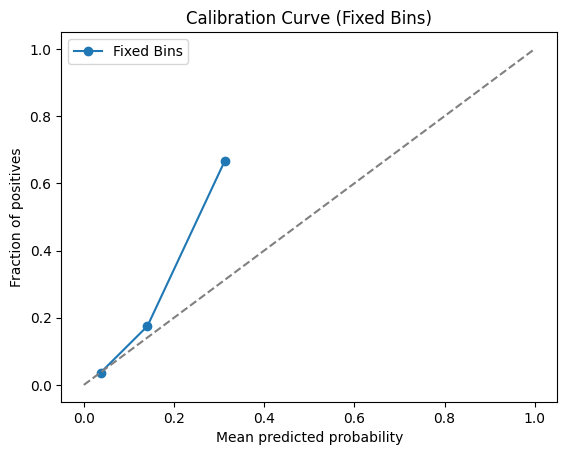

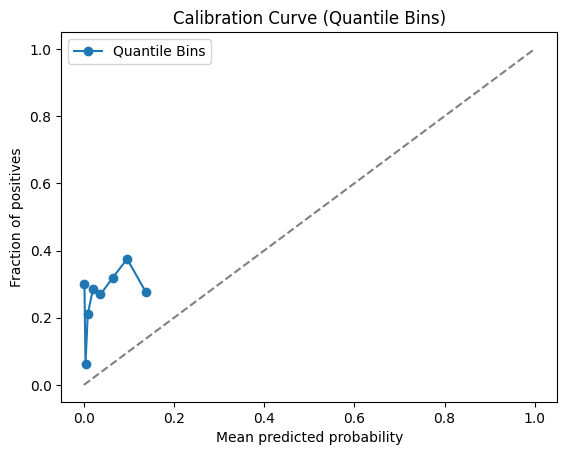

In [2]:
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute scale_pos_weight
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

print(f"scale_pos_weight = {scale_pos_weight:.2f}")

# Step 1 — Train LightGBM base model
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
lgb_model.fit(X_train, y_train)

# Step 2 — Calibrate with isotonic regression
calibrated_model = CalibratedClassifierCV(lgb_model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)

# Step 3 — Predict probabilities
y_test_proba = calibrated_model.predict_proba(X_test)[:, 1]

# Metrics
brier = brier_score_loss(y_test, y_test_proba)
auc_roc = roc_auc_score(y_test, y_test_proba)
auprc = average_precision_score(y_test, y_test_proba)

print(f"Brier score: {brier:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUPRC: {auprc:.4f}")

# Calibration Curve — fixed bins
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_test_proba, n_bins=8
)
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Fixed Bins')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Fixed Bins)')
plt.legend()
plt.show()

# Calibration Curve — quantile bins
y_proba_series = pd.Series(y_test_proba)
bins_quantile = pd.qcut(y_proba_series, q=8, duplicates='drop')

bin_avg_pred = y_proba_series.groupby(bins_quantile, observed=True).mean()
bin_frac_pos = pd.Series(y_test).groupby(bins_quantile, observed=True).mean()

plt.plot(bin_avg_pred, bin_frac_pos, marker='o', label='Quantile Bins')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Quantile Bins)')
plt.legend()
plt.show()
